In [4]:
# import os
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"
import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from scipy.stats import skew, kurtosis
# from scipy.fftpack import fft

# from keras_tuner import HyperModel
# from keras_tuner.tuners import RandomSearch

c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [5]:
df_sequential = pd.read_csv('subsequences_raw.csv')
df_sequential_new_user = pd.read_csv('subsequences_test_raw.csv')
df_sequential.head()



,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",40,2
1,0,"[1.3777305229373487, 1.5960753374387007, 1.203...","[1.1114693, 1.215011, 0.9126327, 0.21197024, 0...","[-0.6337727, -0.82894415, -0.40378192, -0.9318...","[-0.5109888, -0.6197228, -0.67347896, -0.37812...",40,2
2,0,"[2.425892007118064, 3.302566174850101, 1.90556...","[1.4813483, 2.0045543, 1.8689423, 1.7660115, 0...","[-1.9147571, -2.6212227, -0.3643811, -3.342960...","[-0.15577064, -0.1337795, -0.07391469, -0.0665...",40,2
3,0,"[0.9513855617281761, 1.9683277319562844, 1.314...","[0.66767573, -1.0225884, 0.19639318, -0.015882...","[-0.6423248, 1.6542231, 1.2999213, -1.4358387,...","[0.21624629, -0.3036, 0.019242255, -0.42760566...",40,2
4,0,"[2.329359891123871, 1.6620954042937637, 0.8495...","[-1.8026633, -0.8240572, 0.4560109, 1.2605205,...","[1.3573426, 1.325883, 0.46822822, -0.1301143, ...","[0.57787853, 0.5705481, 0.54275376, 0.66553766...",40,2


In [6]:
def prepare_data(df_sequential):
    """
    Prepares the sequential data for further processing.

    Args:
        df_sequential (pd.DataFrame): DataFrame containing the sequential data.

    Returns:
        tuple: Processed feature data (X_data) and labels (y_sequential)
    """
    # Drop unnecessary columns and separate features and labels
    X_sequential = df_sequential.drop(columns=['new_user_id', 'num_of_samples', 'signal_length_in_sec'])
    y_sequential = df_sequential['new_user_id']

    # # Extract the number of samples
    # num_of_samples = df_sequential['num_of_samples'].iloc[0]

    # Convert the lists in 'total_acc', 'x_acc', 'y_acc', 'z_acc' columns to numpy arrays
    def convert_to_array(series: pd.Series):
        return np.array(series.apply(eval).to_list())

    X_total_acc = convert_to_array(X_sequential['total_acc'])
    X_x_acc = convert_to_array(X_sequential['x_acc'])
    X_y_acc = convert_to_array(X_sequential['y_acc'])
    X_z_acc = convert_to_array(X_sequential['z_acc'])

    # Stack the accelerometer data along the last dimension
    X_data = np.stack((X_total_acc, X_x_acc, X_y_acc, X_z_acc), axis=-1)

    # Ensure the shape is correct (samples, timesteps, features)
    print(X_data.shape)  # Expected: (num_samples, num_of_samples, 4)

    return X_data, y_sequential


X_data, y_sequential = prepare_data(df_sequential)
X_data_new_user, y_sequential_new_user = prepare_data(df_sequential_new_user)

# Split the data
X_train_sequential, X_test_sequential, y_train_sequential, y_test_sequential = train_test_split(X_data, y_sequential, test_size=0.2, random_state=42)
X_train_new_user, X_test_new_user, y_train_new_user, y_test_new_user = train_test_split(X_data_new_user, y_sequential_new_user, test_size=0.2, random_state=42)

(30993, 40, 4)
(312, 40, 4)


In [7]:
num_classes = y_sequential.nunique()

print(num_classes)

190


In [8]:
# Define the model creation function
def create_lstm_model(input_shape, num_classes=10):
    """Creates a Keras LSTM model for accelerometer data classification.

    Args:
        input_shape (tuple): Shape of the input data (time_steps, features).
        num_classes (int): Number of classes for classification (default: 10).

    Returns:
        keras.Model: The compiled LSTM model.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape, name="input_acceleration"),

        # LSTM layers
        keras.layers.LSTM(64, return_sequences=True, name="lstm_1"), 
        keras.layers.LSTM(32, name="lstm_2"), 

        # Dense layers for classification
        keras.layers.Dense(64, activation="relu", name="dense_1"),
        keras.layers.Dropout(0.5, name='dropout'),  # Add dropout for regularization
        keras.layers.Dense(num_classes, activation="softmax", name="output_class_base"),
    ])
    return model

In [9]:
# model = create_lstm_model(input_shape=X_train_sequential.shape[1:], num_classes=num_classes)
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
#     metrics=["accuracy"]
    
# )

In [10]:
# no of different users
num_classes = max(y_sequential)+1

input_shape = (X_train_sequential.shape[1], X_train_sequential.shape[2])  # timesteps, features
model = create_lstm_model(input_shape, num_classes=num_classes)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
    metrics=["accuracy"]
    
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 40, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_class_base (Dense)       │ (None, 192)            │        12,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,672 (174.50 KB)

 Trainable params: 44,672 (174.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


model.build(input_shape=(None, X_train_sequential.shape[1], X_train_sequential.shape[2]))

In [27]:
# if already trained model is available
# model.load_weights('gait_cycle_lstm_2sec_weights')

In [32]:
# Train the model
history = model.fit(
    X_train_sequential,
    y_train_sequential,
    epochs=100,  # Adjust the number of epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(X_test_sequential, y_test_sequential),
    callbacks=[early_stopping, reduce_lr, tensorboard]
)

Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.0903 - loss: 4.4240 - val_accuracy: 0.3228 - val_loss: 2.5535 - learning_rate: 0.0010
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2789 - loss: 2.6870 - val_accuracy: 0.4397 - val_loss: 1.9005 - learning_rate: 0.0010
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.3879 - loss: 2.1547 - val_accuracy: 0.5733 - val_loss: 1.5096 - learning_rate: 0.0010
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4807 - loss: 1.8017 - val_accuracy: 0.6280 - val_loss: 1.2866 - learning_rate: 0.0010
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5612 - loss: 1.5429 - val_accuracy: 0.7132 - val_loss: 1.0484 - learning_rate: 0.0010
Epoch 6/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.6320 - loss: 1.3107 - val_accuracy: 0.7495 - val_loss: 0.9035 - learning_rate: 0.0010
Epoch 7/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.6

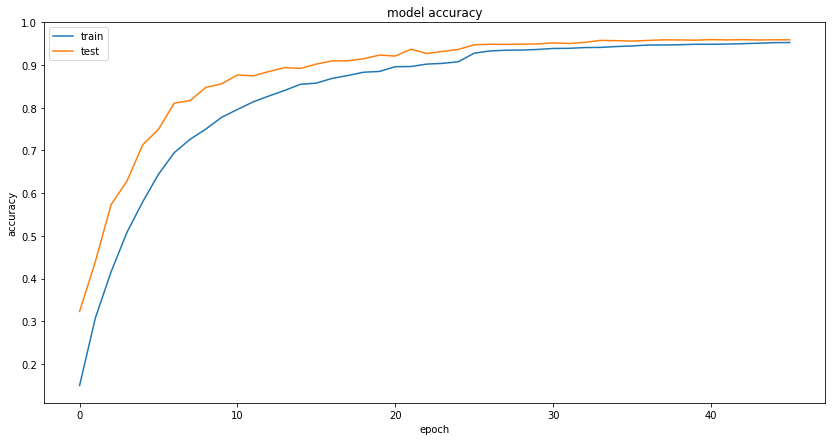

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# save model weights to .h5 file
# model.save_weights('gait_cycle_lstm_2sec_.weights.h5')
# model.save('gait_cycle_lstm_2sec.h5')

save_path = 'gait_cycle_lstm_2sec'

tf.saved_model.save(model, save_path)


INFO:tensorflow:Assets written to: gait_cycle_lstm_2sec\assets


INFO:tensorflow:Assets written to: gait_cycle_lstm_2sec\assets


In [12]:
model.load_weights('gait_cycle_lstm_2sec_.weights.h5')

c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
num_samples = X_train_sequential.shape[0]
num_timesteps = X_train_sequential.shape[1]
num_features = X_train_sequential.shape[2]

print(X_train_sequential.shape)

num_classes

(24794, 40, 4)


192

In [14]:
base_model = create_lstm_model(input_shape=(num_timesteps, num_features), num_classes=num_classes)  # Your original num_classes
base_model.load_weights("gait_cycle_lstm_2sec_.weights.h5")

# Freeze the LSTM and Dense layers
for layer in base_model.layers: #[:-1]:  
    layer.trainable = False

# Create a new classification head
new_head = keras.Sequential([
    keras.layers.Dense(64, activation="relu", name="dense_new"),
    keras.layers.Dropout(0.5, name="dropout_new"),
    keras.layers.Dense(num_classes+1, activation="softmax", name="output_new")  # Increased number of classes
])

new_user_model = keras.Sequential([
    base_model,
    new_head
])

new_user_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
new_user_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │        44,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,672 (174.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 44,672 (174.50 KB)

In [16]:

# Train the model
history = new_user_model.fit(
    X_train_new_user,
    y_train_new_user,
    epochs=10,  # Adjust the number of epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(X_test_new_user, y_test_new_user),
    callbacks=[early_stopping, reduce_lr, tensorboard]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.0164 - loss: 5.2174 - val_accuracy: 0.2857 - val_loss: 5.1852 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1290 - loss: 5.1735 - val_accuracy: 0.3492 - val_loss: 5.1425 - learning_rate: 0.0010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3440 - loss: 5.1412 - val_accuracy: 0.5873 - val_loss: 5.0972 - learning_rate: 0.0010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6734 - loss: 5.0864 - val_accuracy: 1.0000 - val_loss: 5.0476 - learning_rate: 0.0010
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8655 - loss: 5.0442 - val_accuracy: 1.0000 - val_loss: 4.9927 - learning_rate: 0.0010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9780 - loss: 4.9812 - val_accuracy: 1.0000 - val_loss: 4.9317 - learning_rate: 0.0010
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 4.9243 - val_accuracy: 

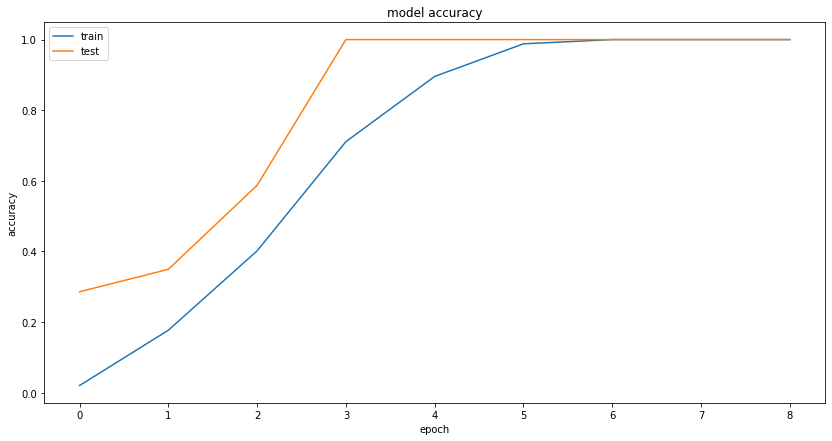

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



In [18]:
X_test_new_user.shape
y_test_new_user.shape

(63,)

In [19]:
from collections import Counter
def majority_voting(model_output):
    predicted_classes = np.argmax(model_output, axis=1)
    counter = Counter(predicted_classes)
    majority_class = counter.most_common(1)[0][0]
    return majority_class
    

output = new_user_model.predict(X_test_new_user)
# Get the majority class with tie-breaking
majority_class_with_tie_breaking = majority_voting(output)

print("Predicted Majority Class with Tie-Breaking:", majority_class_with_tie_breaking)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicted Majority Class with Tie-Breaking: 186


### EVERYTHING BELOW IS EXPERIMENTAL AND NOT WORKING AS IT SHOULD







































In [66]:
base_model.load("gait_cycle_lstm_2sec.h5")

#### Now we need to hack around a bit
As TFLite currently does not support adding layers ad hoc, we now add the new head to the model we want to export and freeze the weights of the base model here already.

In [20]:
num_classes = max(y_sequential)+1
num_classes

192

In [21]:
base_model_from_weights = create_lstm_model(input_shape=(num_timesteps, num_features), num_classes=num_classes)  # Your original num_classes
base_model_from_weights.load_weights("gait_cycle_lstm_2sec_.weights.h5")


base_model_from_weights.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
    metrics=["accuracy"]
    
)

for layer in base_model_from_weights.layers: #[:-1]:  
    layer.trainable = False


new_head = keras.Sequential([
    keras.layers.Dense(64, activation="relu", ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes+5, activation="softmax")  # Increased number of classes, supports 5 new users
    # keras.layers.Dense(1, activation='softmax')  # Placeholder output, we will reshape this on-device using the java api, like shown below
])


new_user_model = keras.Sequential([
    base_model_from_weights,
    new_head
])

class ModelToConvert(tf.Module):
    def __init__(self):
        self.model = new_user_model
        
        self.model.compile(
            optimizer="adam",
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
            metrics=["accuracy"]
        )
        # self.seed_generator_state = tf.Variable(
        #     initial_value=tf.random.uniform([2],  minval=0, maxval=10, dtype=tf.int32),
        #     trainable=False,  
        #     name="seed_generator_state"
        # )

    # def __call__(self, x, training=False):
    #     return self.model(x, training=training)


    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32),
        tf.TensorSpec(shape=[None], dtype=tf.int32)
    ])
    def train(self, X, y):
        tf.random.set_seed(42)
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            loss = self.model.compiled_loss(y, predictions)
            # acc = self.model.compiled_metrics.update_state(y, predictions)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        print(self.model.compiled_metrics)

        # Update metrics
        self.model.compiled_metrics.update_state(y, predictions)

        return {'loss': loss, #'accuracy': acc.result()
                }

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32)
    ])
    def infer(self, x):
        return self.model(x, training=False)
        
    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def save(self, checkpoint_path):
    #     checkpoint = tf.train.Checkpoint(model=self.model)
    #     saved_path = checkpoint.write(checkpoint_path)
    #     return {'checkpoint_path': saved_path}

    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def restore(self, checkpoint_path):
    #     checkpoint = tf.train.Checkpoint(model=self.model)

    #     try:
    #         checkpoint.restore(checkpoint_path)
    #         return {'restored': True}
    #     except tf.errors.NotFoundError:
    #         # Handle the case where the checkpoint file is not found
    #         return {'restored': False, 'error': 'Checkpoint not found'}

In [ ]:
base_model_from_weights = create_lstm_model(input_shape=(num_timesteps, num_features), num_classes=num_classes)  # Your original num_classes
base_model_from_weights.load_weights("gait_cycle_lstm_2sec_.weights.h5")


base_model_from_weights.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
    metrics=["accuracy"]
    
)

for layer in base_model_from_weights.layers: #[:-1]:  
    layer.trainable = False


new_head = keras.Sequential([
    keras.layers.Dense(64, activation="relu", ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes+5, activation="softmax")  # Increased number of classes, supports 5 new users
    # keras.layers.Dense(1, activation='softmax')  # Placeholder output, we will reshape this on-device using the java api, like shown below
])


new_user_model = keras.Sequential([
    base_model_from_weights,
    new_head
])

class ModelToConvert(tf.Module):
    def __init__(self):
        self.model = tf.keras.Sequential([
            keras.layers.InputLayer(shape=input_shape, name="input_acceleration"),      

            # LSTM layers
            keras.layers.LSTM(64, return_sequences=True, name="lstm_1"), 
            keras.layers.LSTM(32, name="lstm_2"), 

            # Dense layers for classification
            keras.layers.Dense(64, activation="relu", name="dense_1"),
            keras.layers.Dropout(0.5, name='dropout'),  # Add dropout for regularization
            keras.layers.Dense(num_classes, activation="softmax", name="output_class_base"),

            keras.layers.Dense(64, activation="relu", ),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes+5, activation="softmax")  # Increased number of classes, supports 5 new users
        ])



        self.model.compile(
            optimizer="adam",
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
            metrics=["accuracy"]
        )
        # self.seed_generator_state = tf.Variable(
        #     initial_value=tf.random.uniform([2],  minval=0, maxval=10, dtype=tf.int32),
        #     trainable=False,  
        #     name="seed_generator_state"
        # )

    # def __call__(self, x, training=False):
    #     return self.model(x, training=training)


    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32),
        tf.TensorSpec(shape=[None], dtype=tf.int32)
    ])
    def train(self, X, y):
        tf.random.set_seed(42)
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            loss = self.model.compiled_loss(y, predictions)
            # acc = self.model.compiled_metrics.update_state(y, predictions)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        print(self.model.compiled_metrics)

        # Update metrics
        self.model.compiled_metrics.update_state(y, predictions)

        return {'loss': loss, #'accuracy': acc.result()
                }

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32)
    ])
    def infer(self, x):
        return self.model(x, training=False)
        
    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def save(self, checkpoint_path):
    #     checkpoint = tf.train.Checkpoint(model=self.model)
    #     saved_path = checkpoint.write(checkpoint_path)
    #     return {'checkpoint_path': saved_path}

    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def restore(self, checkpoint_path):
    #     checkpoint = tf.train.Checkpoint(model=self.model)

    #     try:
    #         checkpoint.restore(checkpoint_path)
    #         return {'restored': True}
    #     except tf.errors.NotFoundError:
    #         # Handle the case where the checkpoint file is not found
    #         return {'restored': False, 'error': 'Checkpoint not found'}

In [22]:
X_train_new_user.shape


(249, 40, 4)

In [23]:

# print first element of the training data
# X_train_new_user[0]

In [24]:
model_to_convert = ModelToConvert()

# train the model
model_to_convert.train(X_train_new_user, y_train_new_user)

c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py:603: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric object at 0x0000024EF0103340>


c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric object at 0x0000024EF086C7F0>


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.364402>}

In [25]:
save_path = 'gait_cycle_lstm_2sec.h5'
# save as saved model
response = tf.saved_model.save(model_to_convert.model, save_path)



INFO:tensorflow:Assets written to: gait_cycle_lstm_2sec.h5\assets


INFO:tensorflow:Assets written to: gait_cycle_lstm_2sec.h5\assets


In [74]:
# to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

: 

In [28]:
predicted_class = majority_voting(model_to_convert.infer(X_test_new_user)['probabilities'])
predicted_class

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'probabilities'

In [27]:
# new_model_to_convert = new_user_model
new_model_to_convert = ModelToConvert()

new_model_to_convert.model.load_weights('gait_cycle_lstm_2sec_.weights.h5')


c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\Lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 6 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['kernel', 'recurrent_kernel', 'bias']

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>, <LSTMCell name=lstm_cell, built=True>, <Dense name=dense_1, built=True>, <Dense name=output_class_base, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]

In [ ]:

new_model_to_convert.save(new_model_to_convert, 'new_model', save_format='h5')


# as saved_model
save_path = 'new_model'

saved_model = tf.saved_model.save(
    new_model_to_convert,
    save_path,
    signatures={
        'train': new_model_to_convert.train.get_concrete_function(),
        'infer': new_model_to_convert.infer.get_concrete_function()
    }
)


In [142]:

# convert to tflite using from_saved_model
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

with open('new_model.tflite', 'wb') as f:
    f.write(tflite_model)


    # export_dir: str,
    # signatures=None,
    # options: tf.saved_model.SaveOptions = None


ValueError: Only support at least one signature key.

In [115]:
model_to_convert2 = ModelToConvert()

In [138]:
tf.saved_model.save(
    model_to_convert2,
    save_path,
    signatures={
        'train':
            model_to_convert2.train.get_concrete_function(),
        'infer':
            model_to_convert2.infer.get_concrete_function()
    }
)

AssertionError: in user code:


    AssertionError: Called a function referencing variables which have been deleted. This likely means that function-local variables were created and not referenced elsewhere in the program. This is generally a mistake; consider storing variables in an object attribute on first call.


In [94]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_convert2)
tflite_model = converter.convert()




import os

cur_path = os.path.abspath('')
print(cur_path)


AttributeError: 'ModelToConvert' object has no attribute 'call'

In [ ]:

# Save the model.
with open(cur_path + 'model.tflite', 'wb') as f:
  f.write(tflite_model)


## TODO NOTES
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb#scrollTo=d8577c80
https://blog.tensorflow.org/2021/11/on-device-training-in-tensorflow-lite.html
https://www.tensorflow.org/lite/android/quickstart
https://www.tensorflow.org/lite/guide/inference